In [1]:
!pip install gdown
#from cld_data_processing import download_data

In [2]:
import gdown
import keras
import pandas as pd
import shutil
import tensorflow as tf
import os
import zipfile

from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.data import Dataset

from typing import NamedTuple, Tuple

import matplotlib.pyplot as plt
import seaborn as sns

2024-03-19 19:34:01.993266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 19:34:01.993400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 19:34:02.110876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class Params(NamedTuple):
    """
    Job Parameters
    """
    image_size: int
    batch_size: int
    epochs: int
    early_stopping: bool
    early_stopping_patience: int
    adjust_learning_rate: bool

In [4]:
tf.random.set_seed(67890)

DEFAULT_PARAMS = Params(200, 196, 50, True, 5, False)
DEFAULT_PARAMS

Params(image_size=200, batch_size=196, epochs=50, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)

`/data/data_processing.py`

In [5]:
def create_ds_tree(x, y, path, name) -> Path:
    """
    
    """
    ds_path = path / name
    if not ds_path.exists():
        ds_path.mkdir(parents=True, exist_ok=True)

        for lab in y.unique():
            (ds_path / str(lab)).mkdir(exist_ok=True)

        source_path = path / "train_images"
        
        for img, lab in zip(x, y):
            src = source_path / img
            dest = ds_path / str(lab) / img
            shutil.move(src, dest)
        
    return ds_path


def create_dataset(path: Path, params: Params) -> Dataset:
    """
    """
    img_size = params.image_size
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[img_size, img_size],
        batch_size=params.batch_size,
    )


def augment_dataset(ds: Dataset, num_repeats: int) -> Dataset:
    def augment(image, label):
        seed = 12345
        image = tf.image.random_flip_left_right(image, seed)
        image = tf.image.random_flip_up_down(image, seed)
        image = tf.image.random_brightness(image, 0.2, seed)
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    return (
        ds
        .repeat(num_repeats)
        .map(augment)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    
def download_data(path: Path, force=False) -> Path:
    """
    """
    url = "https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT"
    output = path / "data.zip"
    if not Path(output).exists() or force:
        gdown.download(url, str(output), quiet=False)
    return output


def data_preprocessing(path: Path, params: Params, force=False) -> Tuple[Dataset, Dataset, Dataset]:
    """
    """
    file = download_data(path, force)
    
    data_path = path / "data"
    if force:
        shutil.rmtree(data_path)
        
    if not data_path.exists():
        data_path.mkdir(parents=True, exist_ok=True)
       
        with zipfile.ZipFile(file, "r") as z:
            z.extractall(data_path)
        
    df_images = pd.read_csv((data_path / "train.csv"))
    
    X_train, X_test, y_train, y_test = train_test_split(df_images.image_id, df_images.label, test_size=0.2, random_state=12)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12)
    
    train_path = create_ds_tree(X_train, y_train, data_path, "train")
    valid_path = create_ds_tree(X_valid, y_valid, data_path, "valid")
    test_path = create_ds_tree(X_test, y_test, data_path, "test")
    
    ds_train = create_dataset(train_path, params)
    ds_valid = create_dataset(valid_path, params)
    ds_test = create_dataset(test_path, params)

    return ds_train, ds_valid, ds_test

In [6]:
# def data_cleanup() -> None:
#     # clean-up
#     try:
#         os.rmdir((data_path / "train_images"))
#         os.remove(file)
#     except Exception:
#          pass

`/model/utils.py`

In [7]:
def model_convnext_tiny(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [8]:
def run_experiment(exp_id: str, sub_exp_id: int, model_fn: str,
                      ds_train_: Dataset, ds_valid_: Dataset, params: Params) -> Tuple[Model, pd.DataFrame]:
    
    model = model_fn(params)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs
    )
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist

In [9]:
def add_results(df_all_results, df_new_results):
    if df_all_results.empty:
        return df_new_results
    else:
        return pd.concat([df_all_results, df_new_results])


def recover_results() -> pd.DataFrame:
    file = "results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame

In [10]:
def plot_experiment_results(df_history: pd.DataFrame, exp_id: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id == exp_id) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_loss = df[["epoch", "loss", "val_loss"]].groupby(["epoch"]).mean()
    df_loss_gap = df[["epoch", "loss_gap"]].groupby(["epoch"]).mean()
    df_acc = df[["epoch", "accuracy", "val_accuracy"]].groupby(["epoch"]).mean()
    df_loss.plot()
    df_loss_gap.plot()
    df_acc.plot();
    
def plot_experiments_comp(df_history: pd.DataFrame, exp_id: list, y_dim: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", y_dim]].groupby(["epoch", "exp_id"]).mean()
    sns.lineplot(data=df_grp, x="epoch", y=y_dim, hue="exp_id")

`main.py`

In [11]:
cwd = os.getcwd()
ds_train, ds_valid, ds_test = data_preprocessing(Path(cwd), DEFAULT_PARAMS)

Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.


In [12]:
df_results = recover_results()

In [19]:
#(m, df_hist) = run_experiment("model_convnext_tiny_sm", 1, model_convnext_tiny, ds_train, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m.evaluate(ds_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.7622 - loss: 0.6507


[0.6435566544532776, 0.7649532556533813]

In [ ]:
m.evaluate(ds_test)

In [20]:
ds_train_aug = augment_dataset(ds_train, 2)

In [21]:
(m2, df_hist) = run_experiment("model_convnext_tiny_aug_sm", 1, model_convnext_tiny, ds_train_aug, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m2.evaluate(ds_test)

Using EarlyStopping
Epoch 1/50


W0000 00:00:1710874636.063295     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/132 ━━━━━━━━━━━━━━━━━━━━ 32s 491ms/step - accuracy: 0.5368 - loss: 1.2958

W0000 00:00:1710874668.093300     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710874668.093669     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710874668.094114     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.5746 - loss: 1.1900

W0000 00:00:1710874698.354414     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710874707.319694     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710874707.320049     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710874707.320558     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 89s 545ms/step - accuracy: 0.5750 - loss: 1.1888 - val_accuracy: 0.6883 - val_loss: 0.8099
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.6677 - loss: 0.8874 - val_accuracy: 0.7079 - val_loss: 0.7607
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.6870 - loss: 0.8308 - val_accuracy: 0.7189 - val_loss: 0.7358
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 51s 390ms/step - accuracy: 0.7024 - loss: 0.7867 - val_accuracy: 0.7276 - val_loss: 0.7158
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.7173 - loss: 0.7552 - val_accuracy: 0.7327 - val_loss: 0.7105
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.7246 - loss: 0.7328 - val_accuracy: 0.7383 - val_loss: 0.6966
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 392ms/step - accuracy: 0.7333 - loss: 0.7092 - val_accuracy: 0.7336 - val_loss: 0.7005
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 391ms/step - accuracy: 0.7437 - loss: 0.6897 - val

[0.6461977362632751, 0.7649532556533813]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

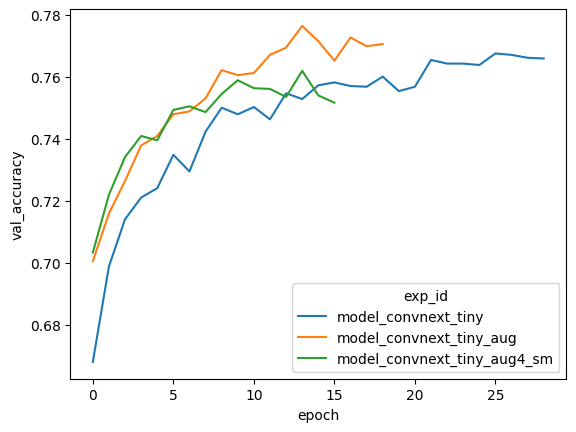

In [16]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug", "model_convnext_tiny_aug4_sm"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

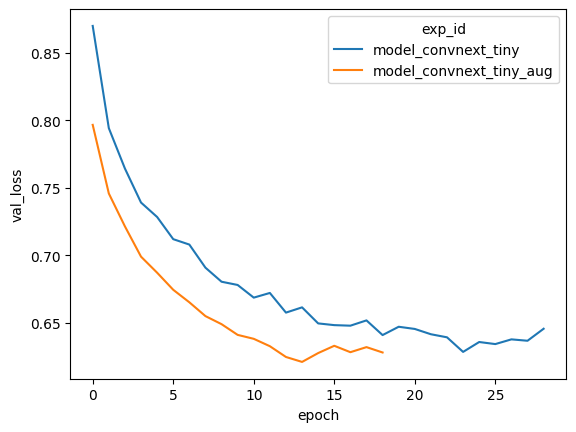

In [29]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug"], "val_loss")

In [13]:
ds_train_aug_lg = augment_dataset(ds_train, 3)

In [14]:
(m3, df_hist) = run_experiment("model_convnext_tiny_aug4_sm", 1, model_convnext_tiny, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m3.evaluate(ds_test)

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1710876888.404715     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710876888.443081     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/198 ━━━━━━━━━━━━━━━━━━━━ 1:11 543ms/step - accuracy: 0.5559 - loss: 1.2797

W0000 00:00:1710876923.920888     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876923.921192     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876923.921644     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876923.924526     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876923.924891     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876923.925388     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6035 - loss: 1.1254

W0000 00:00:1710876980.605474     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876995.701193     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876995.701600     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710876995.702038     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 135s 545ms/step - accuracy: 0.6037 - loss: 1.1247 - val_accuracy: 0.7033 - val_loss: 0.7902
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.6863 - loss: 0.8396 - val_accuracy: 0.7220 - val_loss: 0.7451
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7109 - loss: 0.7794 - val_accuracy: 0.7341 - val_loss: 0.7184
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7240 - loss: 0.7427 - val_accuracy: 0.7409 - val_loss: 0.6969
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7370 - loss: 0.7148 - val_accuracy: 0.7395 - val_loss: 0.6881
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7440 - loss: 0.6852 - val_accuracy: 0.7493 - val_loss: 0.6714
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7580 - loss: 0.6570 - val_accuracy: 0.7505 - val_loss: 0.6659
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7669 - loss: 0.6348 - va

[0.6419883370399475, 0.7633177638053894]

In [17]:
df_results.head()

,Unnamed: 0.1,Unnamed: 0,index,accuracy,loss,val_accuracy,val_loss,exp_id,sub_exp_id,epoch
0,0.0,0.0,0,0.594220,1.156284,0.667991,0.869793,model_convnext_tiny,1,0
1,1.0,1.0,1,0.660435,0.907906,0.698832,0.794085,model_convnext_tiny,1,1
2,2.0,2.0,2,0.681312,0.845324,0.714019,0.764165,model_convnext_tiny,1,2
3,3.0,3.0,3,0.695022,0.809372,0.721028,0.738957,model_convnext_tiny,1,3
4,4.0,4.0,4,0.707954,0.784043,0.724065,0.728263,model_convnext_tiny,1,4


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

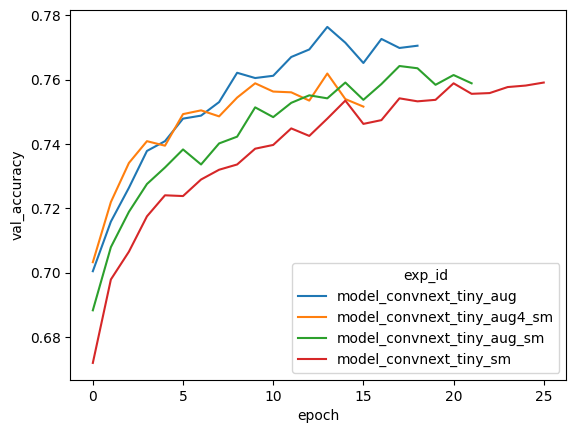

In [19]:
plot_experiments_comp(df_results,["model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_accuracy")

In [21]:
def model_convnext_tiny_1fc(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [22]:
(m4, df_hist) = run_experiment("model_convnext_tiny_1fc", 1, model_convnext_tiny_1fc, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m4.evaluate(ds_test)

Using EarlyStopping
Epoch 1/50


W0000 00:00:1710879459.300541     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/198 ━━━━━━━━━━━━━━━━━━━━ 54s 413ms/step - accuracy: 0.5653 - loss: 1.2253

W0000 00:00:1710879486.287257     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879486.287631     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879486.288096     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879486.291170     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879486.291581     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879486.292051     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6132 - loss: 1.0714

W0000 00:00:1710879534.739911     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879544.430567     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879544.430939     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710879544.431438     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/198 ━━━━━━━━━━━━━━━━━━━━ 100s 433ms/step - accuracy: 0.6134 - loss: 1.0708 - val_accuracy: 0.7112 - val_loss: 0.7692
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7007 - loss: 0.8009 - val_accuracy: 0.7334 - val_loss: 0.7269
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7246 - loss: 0.7440 - val_accuracy: 0.7393 - val_loss: 0.7025
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7400 - loss: 0.7050 - val_accuracy: 0.7439 - val_loss: 0.6898
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7497 - loss: 0.6771 - val_accuracy: 0.7500 - val_loss: 0.6750
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 370ms/step - accuracy: 0.7605 - loss: 0.6484 - val_accuracy: 0.7565 - val_loss: 0.6653
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7705 - loss: 0.6276 - val_accuracy: 0.7535 - val_loss: 0.6590
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 73s 369ms/step - accuracy: 0.7789 - loss: 0.6072 - va

[0.6196820735931396, 0.7740654349327087]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

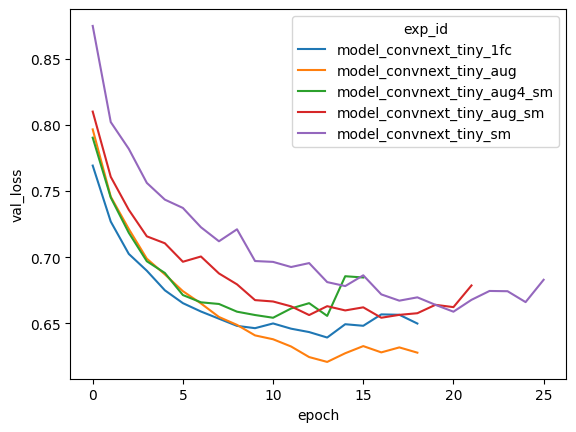

In [24]:
plot_experiments_comp(df_results,["model_convnext_tiny_1fc", "model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_loss")

In [18]:
#!rm -rf /kaggle/working/data